In [60]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
# import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn_sparsify_subset_fix_acc import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%time 

dataset = 'MNIST'
hidden_size = [64]

num_samples_per_class = 100000 #1000

# Easy task
class1 = 0
class2 = 7

all_original_acc_easy = []
all_results_easy = []

# activation_fn = '_relu'
activation_fn = 'tanh'
# activation_fn = '_sigmoid'

new_range = list(range(10)) + list(range(11, 20))

for i in new_range: 
    #path = f'/home/rjankow/data/task_complexity.NOBACKUP/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    path = f'/home/rjankow/data/task_complexity/fix_accuracy.NOBACKUP/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}_{activation_fn}/'
    original_acc_easy, results_easy = sparsify_mlp(9, path, [class1, class2], num_samples_per_class,
                                         hidden_size, verbose=False, activation_fn=activation_fn)
    all_original_acc_easy.append(original_acc_easy)
    all_results_easy.append(results_easy)

 84%|████████▍ | 32/38 [05:25<01:00, 10.09s/it]

In [ ]:
%%time

# Hard task
class1 = 7
class2 = 9

all_original_acc_hard = []
all_results_hard = []

for i in new_range:
    #path = f'/home/rjankow/data/task_complexity.NOBACKUP/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    path = f'/home/rjankow/data/task_complexity/fix_accuracy.NOBACKUP/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}_{activation_fn}/'
    original_acc_hard, results_hard = sparsify_mlp(9, path, [class1, class2], num_samples_per_class,
                                                   hidden_size, verbose=False, activation_fn=activation_fn)
    
    all_original_acc_hard.append(original_acc_hard)
    all_results_hard.append(results_hard)

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shaded_area(x, data, plot_style='median_iqr', label='', color='blue', alpha=0.2, linestyle='-', ax=None):
    """
    Plots a shaded area with a central line based on the provided data.
    
    Parameters:
      x (array-like): x-axis values.
      data (np.ndarray): 2D array where each row corresponds to a run.
      plot_style (str): 'mean_std' for mean ± standard deviation,
                        'median_iqr' for median with interquartile range.
      label (str): Label for the central line.
      color (str): Color for the shaded area and line.
      alpha (float): Transparency for the shaded area.
    """
    if plot_style == 'mean_std':
        central = np.mean(data, axis=0)
        lower = central - np.std(data, axis=0)
        upper = central + np.std(data, axis=0)
    elif plot_style == 'median_iqr':
        central = np.median(data, axis=0)
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
    else:
        raise ValueError("Unsupported plot_style. Use 'mean_std' or 'median_iqr'.")
    
    if ax is not None:
        ax.fill_between(x, lower, upper, alpha=alpha, color=color)
        ax.plot(x, central, color=color, label=label, linestyle=linestyle)
    else:
        plt.fill_between(x, lower, upper, alpha=alpha, color=color)
        plt.plot(x, central, color=color, label=label, linestyle=linestyle)

def extract_values(results, index):
    """
    Extracts values from a list of dictionaries.
    
    Parameters:
      results (list): List of dictionaries with values as iterables.
      index (int): The index to extract from each value tuple.
      
    Returns:
      np.ndarray: 2D array with extracted values.
    """
    vals = []
    for r in results:
        vals.append([x[index] for x in r.values()])
    return np.array(vals)

In [55]:
# colors = [
#   "#a00e00",
#   "#d04e00",
#   "#f6c200",
#   "#0086a8",
#   "#132b69"
# ]

# colors = ["#a00e00", "#132b69"]
# colors = ['#3b7c70', '#ce9642']

colors = ['#ef8a47', '#528fad']

/tmp/ipykernel_699690/2893693113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 0)
/tmp/ipykernel_699690/2893693113.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals_signed_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 1)
/tmp/ipykernel_699690/2893693113.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performi

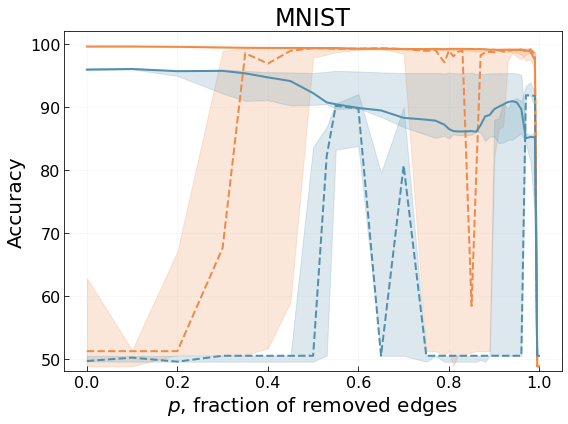

In [65]:
all_fraction_non_zero = np.array(list(all_results_easy[0].keys()))
x = 1 - all_fraction_non_zero  # x-axis: fraction of removed edges

# plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black', label='Easy Original')

# vals_original_easy = extract_values(all_results_easy, 0)
vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Easy', color=colors[0])

# vals_signed_easy = extract_values(all_results_easy, 1)
vals_signed_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='Easy (signed)', 
                 color=colors[0], linestyle='--')

# plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black', label='Hard original')

# vals_original_hard = extract_values(all_results_hard, 0)
vals_original_hard = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 60)], 0)

plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='Hard', 
                 color=colors[-1])

# vals_signed_hard = extract_values(all_results_hard, 1)
vals_signed_hard = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 60)], 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='Hard (signed)', 
                 color=colors[-1], linestyle='--')

# plt.legend(loc=(0.01, 0.05))
plt.ylabel('Accuracy')
plt.xlabel('$p$, fraction of removed edges')
plt.ylim(48, 102)

plt.title('MNIST')

plt.tight_layout()

# plt.savefig("../plots/paper/prune_mnist_d64.pdf")
# plt.savefig("../plots/paper/prune_mnist_d32.pdf")
# plt.savefig("../plots/paper/prune_mnist_d128.pdf")

# plt.savefig("../plots/paper/prune_mnist_d64_sigmoid.pdf")

In [58]:
std_weights_hard = []
std_weights_easy = []

for i in range(20):
    class1 = 7
    class2 = 9
    weights_hard = []
    
    # Layer 0
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer0_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))
    # Layer 1
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer1_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))

    
    class1 = 0
    class2 = 7
    weights_easy = []
    
    # Layer 0
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer0_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))
    
    # Layer 1
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer1_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))

            
    std_weights_hard.append(np.std(weights_hard))
    std_weights_easy.append(np.std(weights_easy))

FileNotFoundError: [Errno 2] No such file or directory: '/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_7_9_dim_64_n_100000_i0tanh/epoch_9_Layer0_edgelist.txt'

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
positions = [1, 2]

data = [std_weights_easy, std_weights_hard]

for idx, (group, pos, color) in enumerate(zip(data, positions, colors)):
    vp = ax.violinplot([group], positions=[pos], widths=0.6, showmedians=True, showextrema=True)
    body = vp['bodies'][0]
    body.set_facecolor(color)
    body.set_edgecolor('black')
    body.set_alpha(0.6)
    verts = body.get_paths()[0].vertices
    verts[verts[:, 0] > pos, 0] = pos

    # Color median, extrema, and central bar
    vp['cmedians'].set_color(color)
    vp['cmedians'].set_linewidth(2)
    vp['cbars'].set_color(color)
    vp['cbars'].set_linewidth(1.5)
    vp['cmins'].set_color(color)
    vp['cmins'].set_linewidth(1.5)
    vp['cmaxes'].set_color(color)
    vp['cmaxes'].set_linewidth(1.5)
    jitter = np.random.normal(loc=pos + 0.15, scale=0.02, size=len(group))
    ax.scatter(jitter, group, color=color, zorder=3, alpha=0.2)

# Labels and formatting
ax.set_xticks(positions)
ax.set_xticklabels(['Easy', 'Hard'])
ax.set_ylabel(r'$\sigma(w)$')
ax.set_title('MNIST')

plt.tight_layout()

# plt.savefig("../plots/paper/std_weights_mnist_d64.pdf")

In [28]:
new_colors = [
  "#3b7c70",
  "#ce9642",
  "#898e9f",
  "#3b3a3e"
]

/tmp/ipykernel_699690/2667574403.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 0)
/tmp/ipykernel_699690/2667574403.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 1)
/tmp/ipykernel_699690/2667574403.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

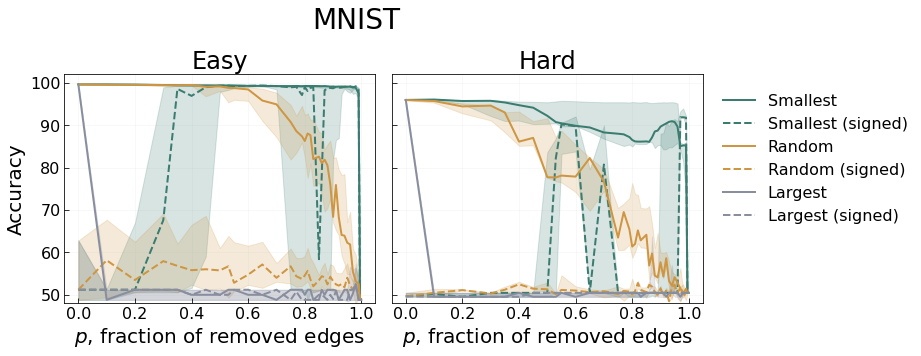

In [66]:
all_fraction_non_zero = np.array(list(all_results_easy[0].keys()))
x = 1 - all_fraction_non_zero  # x-axis: fraction of removed edges

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

### Easy
# Smallest
vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Smallest', color=new_colors[0], ax=axes[0])

vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 1)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Smallest (signed)', color=new_colors[0], ax=axes[0], linestyle='--')

# Random
vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 2)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Random', color=new_colors[1], ax=axes[0])

vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 3)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Random (signed)', color=new_colors[1], ax=axes[0], linestyle='--')

# Large
vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 4)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Largest', color=new_colors[2], ax=axes[0])

vals_original_easy = extract_values([all_results_easy[int(idx)] for idx in np.argwhere(np.array(all_original_acc_easy) > 70)], 5)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Largest (signed)', color=new_colors[2], ax=axes[0], linestyle='--')


### Hard
# Smallest
vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Smallest', color=new_colors[0], ax=axes[1])

vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 1)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Smallest (signed)', color=new_colors[0], ax=axes[1], linestyle='--')

# Random
vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 2)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Random', color=new_colors[1], ax=axes[1])

vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 3)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Random (signed)', color=new_colors[1], ax=axes[1], linestyle='--')

# Large
vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 4)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Largest', color=new_colors[2], ax=axes[1])

vals_original_easy = extract_values([all_results_hard[int(idx)] for idx in np.argwhere(np.array(all_original_acc_hard) > 70)], 5)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Largest (signed)', color=new_colors[2], ax=axes[1], linestyle='--')

# axes[1].legend()

axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('$p$, fraction of removed edges')
axes[1].set_xlabel('$p$, fraction of removed edges')
axes[0].set_ylim(48, 102)

axes[0].set_title('Easy')
axes[1].set_title('Hard')

fig.suptitle('MNIST', fontsize=28)


plt.subplots_adjust(right=0.8)

# New axes: [left, bottom, width, height] in figure coordinates
leg_ax = fig.add_axes([0.82, 0.15, 0.15, 0.7])
leg_ax.axis('off')

# Get handles/labels (deduplicate)
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))

leg_ax.legend(by_label.values(), by_label.keys(), loc=(1.2,0.3))

plt.tight_layout()